2 metre temperature / (kelvin)      (time: 161711; latitude: 34; longitude: 57)
    Dimension coordinates:
        time                             x                 -              -
        latitude                         -                 x              -
        longitude                        -                 -              x
    Auxiliary coordinates:
        day_of_month                     x                 -              -
        hour                             x                 -              -
        month                            x                 -              -
        season                           x                 -              -
        season_year                      x                 -              -
        year                             x                 -              -
    Attributes:
        Conventions                 'CF-1.7'
Shapefile loaded


/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:1978: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:1978: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


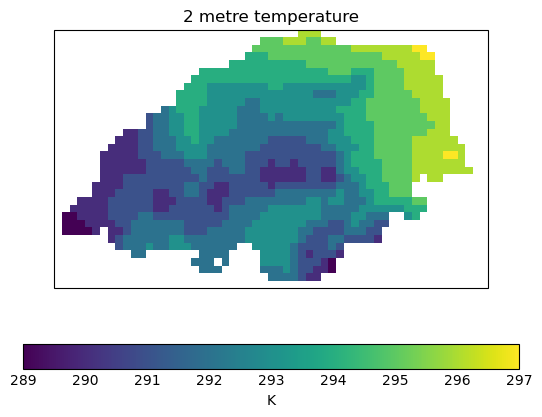

In [1]:
import os
import numpy as np
import pandas as pd
import iris
import iris.coord_categorisation
import iris.analysis
import iris.quickplot as qplt
from iris.cube import CubeList
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import PercentFormatter
import geopandas as gpd
import cartopy.crs as ccrs
import basic_info

filepath = f'{os.getcwd()}/Data/heat_index_cubes/heat_index'

def extract_yearly_cubes(cube):
    yearly_cubes = []
    years = set(cube.coord('season_year').points)
    for year in years:
        year_constraint = iris.Constraint(season_year=year)
        year_cube = cube.extract(year_constraint)
        yearly_cubes.append(year_cube)
    
    return iris.cube.CubeList(yearly_cubes)

def add_season_year_dim(cube, seasons=None):
    '''A function that returns a cube with the season_year attached as a
    dimension

    Input args:
    ----------
    cube  -- the cube to add the season_year to
    '''
    try:
        cube.remove_coord('season_year')
    except iris.exceptions.CoordinateNotFoundError:
        pass
    if seasons:
        iris.coord_categorisation.add_season_year(cube, 'time', name='season_year',
                                        seasons=seasons)
    else:
        iris.coord_categorisation.add_season_year(cube, 'time', name='season_year',
                                        seasons=('djf','mam','jja','son')) # Define if different seasons are needed
    return cube

def add_hour_dim(cube):
    '''A function that returns a cube with the hour attached as a
    dimension

    Input args:
    ----------
    cube  -- the cube to add the hour to
    '''
    try:
        cube.remove_coord('hour')
    except:
        pass
    iris.coord_categorisation.add_hour(cube, 'time', name='hour')
    return cube

lu_and_romps_cube = iris.load_cube(f'{filepath}_{22}_cube.nc')

tas_cube = iris.load_cube(basic_info.tas_filepath)
rh_cube = iris.load_cube(basic_info.rh_filepath)

add_season_year_dim(tas_cube)
add_season_year_dim(rh_cube)

add_hour_dim(tas_cube)
add_hour_dim(rh_cube)

print(lu_and_romps_cube)

shapefile = gpd.read_file(basic_info.shapefile_outline)
print('Shapefile loaded')

qplt.pcolormesh(lu_and_romps_cube[0])

def add_day_month_season_year_dims(cube):
    # Add day of month
    try:
        cube.remove_coord('day_of_month')
    except iris.exceptions.CoordinateNotFoundError:
        pass
    iris.coord_categorisation.add_day_of_month(cube, 'time', name='day_of_month')
    
    # Add month
    try:
        cube.remove_coord('month')
    except iris.exceptions.CoordinateNotFoundError:
        pass
    iris.coord_categorisation.add_month(cube, 'time', name='month')
    
    # Add season year
    try:
        cube.remove_coord('season_year')
    except iris.exceptions.CoordinateNotFoundError:
        pass
    iris.coord_categorisation.add_season_year(cube, 'time', name='season_year')
    
    return cube

add_day_month_season_year_dims(lu_and_romps_cube)

iris.coord_categorisation.add_day_of_year(lu_and_romps_cube, 'time')

In [2]:
def hourly_to_daily_mean(cube):
    # Add day, month, and season year dimensions
    add_day_month_season_year_dims(cube)
    
    # Aggregate by day of month, month, and season year
    daily_means = cube.aggregated_by(['day_of_month', 'month', 'season_year'], iris.analysis.MEAN)
    
    return daily_means

def mean_of_daily_means(cube):
    daily_means = hourly_to_daily_mean(cube)
    return daily_means.collapsed('time', iris.analysis.MEAN)

def hourly_to_daily_max(cube):
    # Add day, month, and season year dimensions
    add_day_month_season_year_dims(cube)
    
    # Aggregate by day of month, month, and season year
    daily_max = cube.aggregated_by(['day_of_month', 'month', 'season_year'], iris.analysis.MAX)
    
    return daily_max

def max_of_daily_max(cube):
    daily_max = hourly_to_daily_max(cube)
    return daily_max.collapsed('time', iris.analysis.MAX)

def hourly_to_daily_min(cube):
    # Add day, month, and season year dimensions
    add_day_month_season_year_dims(cube)
    
    # Aggregate by day of month, month, and season year
    daily_min = cube.aggregated_by(['day_of_month', 'month', 'season_year'], iris.analysis.MIN)
    
    return daily_min

def min_of_daily_min(cube):
    daily_min = hourly_to_daily_min(cube)
    return daily_min.collapsed('time', iris.analysis.MIN)

In [3]:
# Specify an output folder for figures
output_folder = f'{os.getcwd()}/outputs'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Frequency and mangitude over time and space (projections)

In [4]:
lu_and_romps_cube = lu_and_romps_cube.aggregated_by(['season_year', 'day_of_year'], iris.analysis.MAX)

In [5]:
def compute_average_days_above_threshold_per_year(cube, threshold):
    """
    Compute the average number of days per year above the given threshold for each cell in the cube.
    
    Args:
        cube (iris.Cube): The input data cube.
        threshold (float): The threshold value.
        
    Returns:
        iris.Cube: A cube containing the average number of days per year above the threshold for each cell.
    """
    # Initialize a list to store the proportion of days above the threshold for each year
    proportions = []
    
    # Iterate over each year
    for year in np.unique(cube.coord('year').points):
        # Extract data for the current year
        year_constraint = iris.Constraint(year=year)
        cube_year = cube.extract(year_constraint)
        
        # Compute the total number of days in the current year for each cell
        total_days = cube_year.shape[0]
        
        # Compute the number of days above the threshold in the current year for each cell
        days_above_threshold = np.sum(cube_year.data > threshold, axis=0)
        
        # Compute the proportion of days above the threshold in the current year
        proportion_above_threshold = days_above_threshold / total_days
        
        # Append the proportion to the list
        proportions.append(proportion_above_threshold)
    
    # Convert the list of proportions to a numpy array
    proportions = np.array(proportions)
    
    # Compute the mean proportion over all years
    mean_proportion_above_threshold = np.mean(proportions, axis=0)
    
    # Convert the mean proportion to a percentage
    mean_proportion_above_threshold *= 100 # Shorthand for mean_proportion_above_threshold = mean_proportion_above_threshold * 100
    
    # Mask the invalid data and zero values
    mean_proportion_above_threshold = np.ma.masked_where(mean_proportion_above_threshold == 0, mean_proportion_above_threshold)
    
    # Create a new cube to store the mean proportion
    mean_proportion_cube = cube[0].copy(data=mean_proportion_above_threshold)
    
    return mean_proportion_cube

In [6]:
lu_and_romps_yearly_cubes = extract_yearly_cubes(lu_and_romps_cube)

## Proportion of days to account for how some years have fewer days

/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(
/opt/anaconda3/envs/testenv/lib/python3.12/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinat

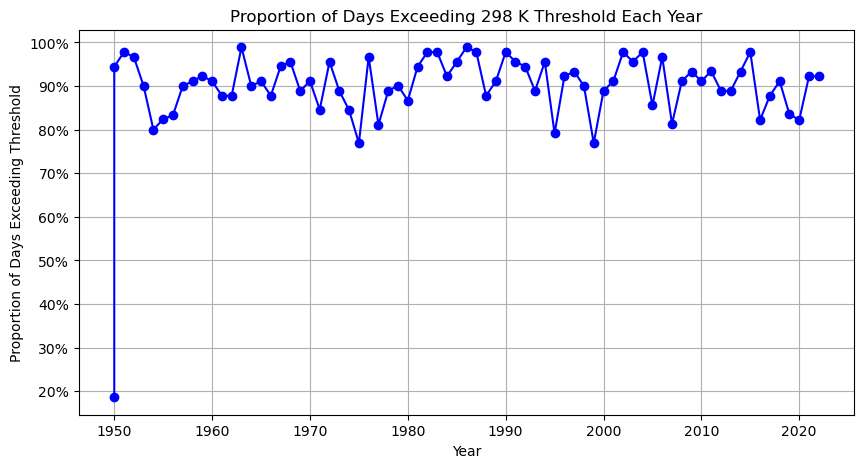

In [7]:
import numpy as np
import iris
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

threshold = 298
timeseries = []

for yearly_cube in lu_and_romps_yearly_cubes:
    # Collapse the cube spatially (latitude and longitude) using the mean
    collapsed_cube = yearly_cube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
    
    # Get the time coordinate points
    time_points = collapsed_cube.coord('time').points
    time_units = collapsed_cube.coord('time').units
    time_dates = time_units.num2date(time_points)
    
    # Convert time points to dates (ignoring hours)
    dates = np.array([date.strftime('%Y-%m-%d') for date in time_dates])
    
    # Check if any value in the cube exceeds the threshold
    days_exceeding_threshold = []
    unique_dates = np.unique(dates)
    
    for date in unique_dates:
        # Get the indices for the current date
        indices = np.where(dates == date)
        
        # Check if any value for the current date exceeds the threshold
        if np.any(collapsed_cube.data[indices] > threshold):
            days_exceeding_threshold.append(date)
    
    # Count the number of days where the threshold is exceeded
    num_days_exceeding_threshold = len(days_exceeding_threshold)
    
    # Get the total number of unique days in the year
    total_days_in_year = len(unique_dates)
    
    # Calculate the proportion of days exceeding the threshold
    proportion_exceeding_threshold = num_days_exceeding_threshold / total_days_in_year
    
    # Get the year from the time coordinate (assuming the first point represents the year)
    year = collapsed_cube.coord('time').cell(0).point.year
    
    # Append the result to the timeseries
    timeseries.append((year, proportion_exceeding_threshold))

# Separate the years and proportions for plotting
years, proportions = zip(*timeseries)

# Remove the final year from the plot
years = years[:-1]
proportions = proportions[:-1]

# Plot the timeseries
plt.figure(figsize=(10, 5))
plt.plot(years, proportions, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Proportion of Days Exceeding Threshold')
plt.title('Proportion of Days Exceeding 298 K Threshold Each Year')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # Formatting y-ticks as percentages
plt.grid(True)
plt.show()

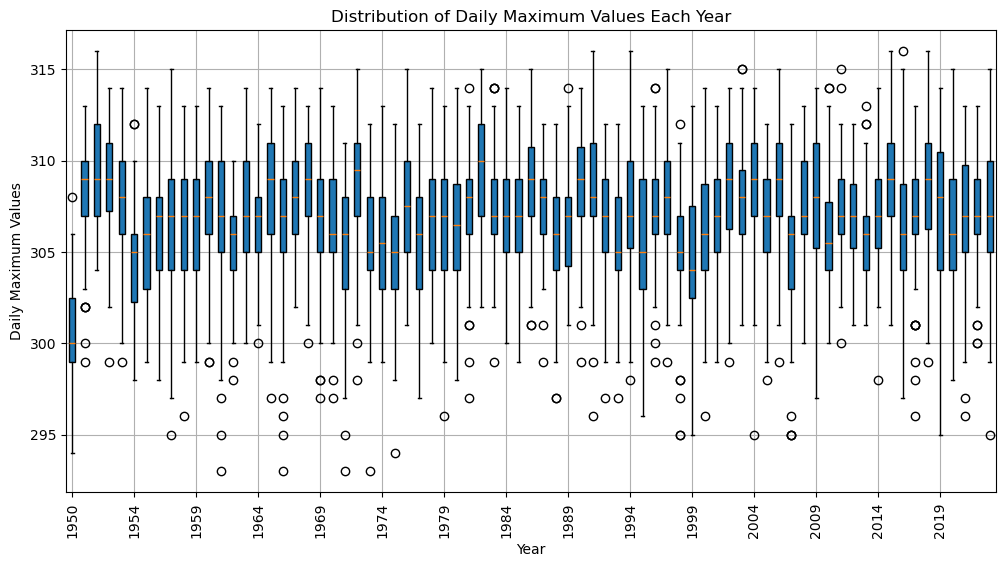

In [8]:
yearly_max_values = []

for yearly_cube in lu_and_romps_yearly_cubes:
    # Get the time coordinate points
    time_points = yearly_cube.coord('time').points
    time_units = yearly_cube.coord('time').units
    time_dates = time_units.num2date(time_points)
    
    # Convert time points to dates (ignoring hours)
    dates = np.array([date.strftime('%Y-%m-%d') for date in time_dates])
    
    # Find unique dates
    unique_dates = np.unique(dates)
    
    daily_max_values = []
    
    for date in unique_dates:
        # Get the indices for the current date
        indices = np.where(dates == date)
        
        # Find the maximum value for the current date
        daily_max = np.max(yearly_cube.data[indices])
        daily_max_values.append(daily_max)
    
    # Append the daily maximum values for the current year
    yearly_max_values.append(daily_max_values)

# Get the years for labeling
years = [yearly_cube.coord('time').cell(0).point.year for yearly_cube in lu_and_romps_yearly_cubes]

# Plot the distribution of daily maximum values for each year
plt.figure(figsize=(12, 6))
plt.boxplot(yearly_max_values, patch_artist=True)
plt.xlabel('Year')
plt.ylabel('Daily Maximum Values')
plt.title('Distribution of Daily Maximum Values Each Year')

# Adjust x-ticks to show every 5 years
plt.xticks(ticks=np.arange(1, len(years) + 1, 5), labels=years[::5], rotation=90)

plt.grid(True)
plt.show()

     1950   1950   1951   1952   1953   1954   1955   1956   1957   1958  ...  \
0   291.0  300.0  304.0  298.0  299.0  293.0  295.0  291.0  297.0  296.0  ...   
1   290.0  299.0  298.0  299.0  298.0  294.0  295.0  294.0  297.0  292.0  ...   
2   291.0  299.0  288.0  292.0  299.0  293.0  291.0  292.0  295.0  292.0  ...   
3   288.0  299.0  293.0  291.0  297.0  294.0  292.0  290.0  293.0  295.0  ...   
4   290.0  298.0  300.0  299.0  294.0  297.0  294.0  292.0  294.0  297.0  ...   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  ...   
86    NaN  291.0  293.0  297.0  292.0  295.0  292.0  294.0  296.0  297.0  ...   
87    NaN  299.0  292.0  299.0  297.0  293.0  292.0  294.0  296.0  298.0  ...   
88    NaN  298.0  299.0  301.0  295.0  294.0  295.0  294.0  298.0  298.0  ...   
89    NaN  287.0  297.0  298.0  299.0  295.0  294.0  293.0  298.0  297.0  ...   
90    NaN    NaN  296.0    NaN    NaN    NaN  296.0    NaN    NaN    NaN  ...   

     2014   2015   2016   2

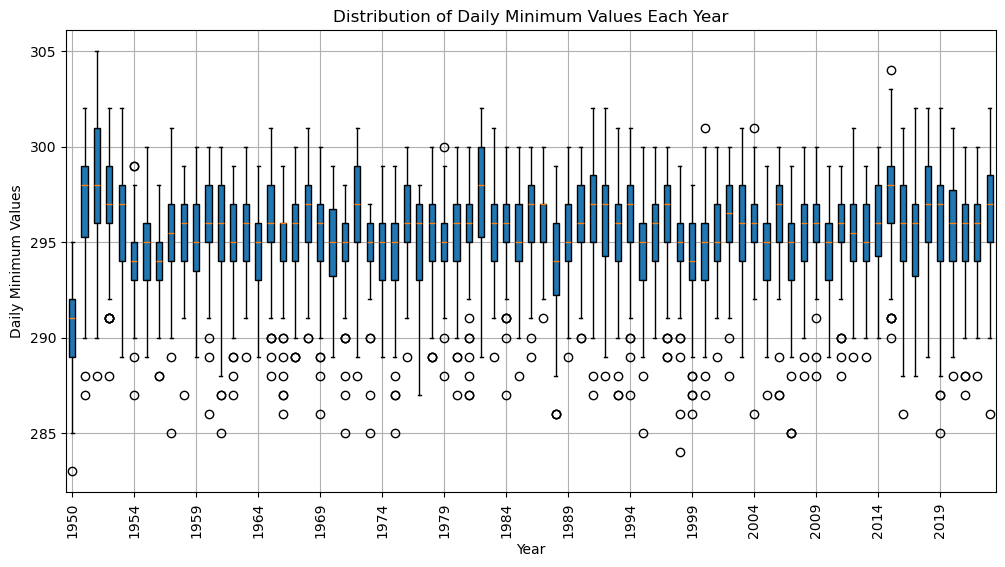

In [9]:
yearly_min_values = []

for yearly_cube in lu_and_romps_yearly_cubes:
    # Get the time coordinate points
    time_points = yearly_cube.coord('time').points
    time_units = yearly_cube.coord('time').units
    time_dates = time_units.num2date(time_points)
    
    # Convert time points to dates (ignoring hours)
    dates = np.array([date.strftime('%Y-%m-%d') for date in time_dates])
    
    # Find unique dates
    unique_dates = np.unique(dates)
    
    daily_min_values = []
    
    for date in unique_dates:
        # Get the indices for the current date
        indices = np.where(dates == date)
        
        # Find the minimum value for the current date
        daily_min = np.min(yearly_cube.data[indices])
        daily_min_values.append(daily_min)
    
    # Append the daily minimum values for the current year
    yearly_min_values.append(daily_min_values)

# Get the years for labeling
years = [yearly_cube.coord('time').cell(0).point.year for yearly_cube in lu_and_romps_yearly_cubes]

# Create a DataFrame for the table
df_min = pd.DataFrame(yearly_min_values, index=years).transpose()

# Display the DataFrame
print(df_min)

# Plot the distribution of daily minimum values for each year
plt.figure(figsize=(12, 6))
plt.boxplot(yearly_min_values, patch_artist=True)
plt.xlabel('Year')
plt.ylabel('Daily Minimum Values')
plt.title('Distribution of Daily Minimum Values Each Year')

# Adjust x-ticks to show every 5 years
plt.xticks(ticks=np.arange(1, len(years) + 1, 5), labels=years[::5], rotation=90)

plt.grid(True)
plt.show()

          1950        1950        1951        1952        1953        1954  \
0   296.728571  306.184821  309.550000  305.955357  305.491071  299.180357   
1   295.708929  306.028571  306.938393  306.122321  305.193750  299.663393   
2   294.406250  304.504464  297.146429  299.733929  307.041071  300.359821   
3   293.446429  305.225893  298.864286  296.736607  303.923214  300.979464   
4   294.485714  303.718750  305.358929  303.836607  302.242857  302.039286   
..         ...         ...         ...         ...         ...         ...   
86         NaN  298.481250  301.616071  305.524107  300.475000  300.254464   
87         NaN  305.272321  300.236607  306.019643  302.961607  299.163393   
88         NaN  304.951786  304.250000  308.218750  302.846429  298.813393   
89         NaN  297.224107  306.097321  305.441071  304.919643  300.558036   
90         NaN         NaN  302.677679         NaN         NaN         NaN   

          1955        1956        1957        1958  ...        

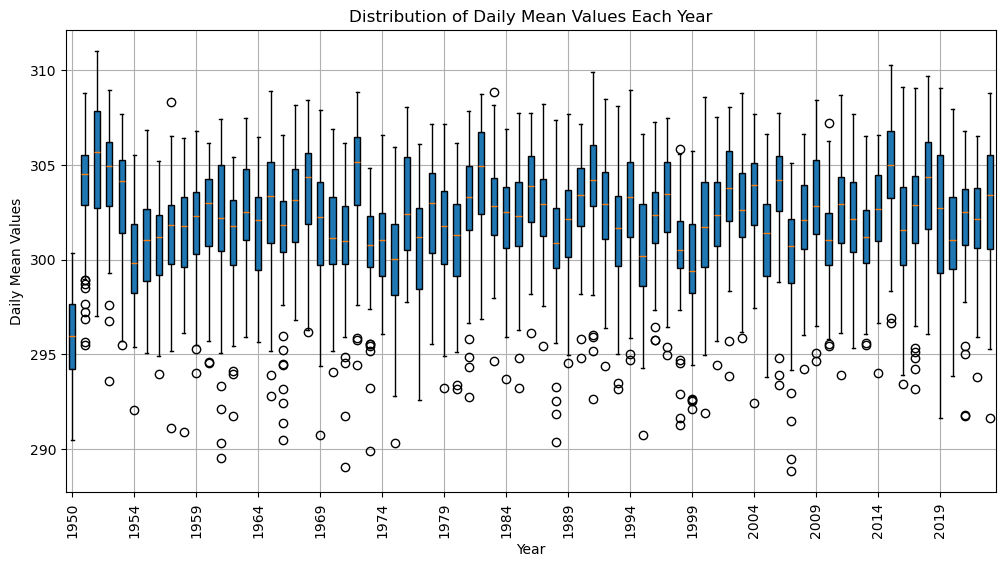

In [10]:
yearly_mean_values = []

for yearly_cube in lu_and_romps_yearly_cubes:
    # Get the time coordinate points
    time_points = yearly_cube.coord('time').points
    time_units = yearly_cube.coord('time').units
    time_dates = time_units.num2date(time_points)
    
    # Convert time points to dates (ignoring hours)
    dates = np.array([date.strftime('%Y-%m-%d') for date in time_dates])
    
    # Find unique dates
    unique_dates = np.unique(dates)
    
    daily_mean_values = []
    
    for date in unique_dates:
        # Get the indices for the current date
        indices = np.where(dates == date)
        
        # Find the mean value for the current date
        daily_mean = np.mean(yearly_cube.data[indices])
        daily_mean_values.append(daily_mean)
    
    # Append the daily mean values for the current year
    yearly_mean_values.append(daily_mean_values)

# Get the years for labeling
years = [yearly_cube.coord('time').cell(0).point.year for yearly_cube in lu_and_romps_yearly_cubes]

# Create a DataFrame for the table
df = pd.DataFrame(yearly_mean_values, index=years).transpose()

# Display the DataFrame
print(df)

# Plot the distribution of daily mean values for each year
plt.figure(figsize=(12, 6))
plt.boxplot(yearly_mean_values, patch_artist=True)
plt.xlabel('Year')
plt.ylabel('Daily Mean Values')
plt.title('Distribution of Daily Mean Values Each Year')

# Adjust x-ticks to show every 5 years
plt.xticks(ticks=np.arange(1, len(years) + 1, 5), labels=years[::5], rotation=90)

plt.grid(True)
plt.show()

# Assumes daily max is from tas max and rh min from here on

In [11]:
lu_and_romps_cube = hourly_to_daily_max(lu_and_romps_cube)

In [12]:
# Define the 10-year intervals
start_year = yearly_cube.coord('time').cell(0).point.year
end_year = yearly_cube.coord('time').cell(-1).point.year
years = list(range(start_year, end_year + 1, 10))

# Initialize a list to store the cubes for each 10-year interval
ten_year_cubes = []

for year in years:
    # Define a constraint for the 10-year interval
    year_constraint = iris.Constraint(time=lambda cell: cell.point.year == year)
    
    # Extract the data for the current 10-year interval
    ten_year_cube = yearly_cube.extract(year_constraint)
    
    if ten_year_cube is not None:
        ten_year_cubes.append(ten_year_cube)

# ten_year_cubes now contains the cubes for every 10 years

In [13]:
plt.figure(figsize=(12, 6))

for period, values in values_per_period.items():
    plt.hist(values, bins=50, alpha=0.5, label=period, edgecolor='k')

plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.title('Distribution of Temperature Values Over 10-Year Periods')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'values_per_period' is not defined

<Figure size 1200x600 with 0 Axes>

### Hours > 298

In [ ]:
threshold = 298
timeseries = []

for yearly_cube in lu_and_romps_yearly_cubes:
    # Get the time coordinate points (assuming daily resolution)
    time_points = yearly_cube.coord('time').points
    
    # Check if any value in the cube exceeds the threshold
    days_exceeding_threshold = np.any(yearly_cube.data > threshold, axis=(1, 2))
    
    # Count the number of days where the threshold is exceeded
    num_days_exceeding_threshold = np.sum(days_exceeding_threshold)
    
    # Get the year from the time coordinate (assuming the first point represents the year)
    year = yearly_cube.coord('time').cell(0).point.year
    
    # Append the result to the timeseries
    timeseries.append((year, num_days_exceeding_threshold))

# Separate the years and counts for plotting
years, counts = zip(*timeseries)

# Remove the final year from the plot
years = years[:-1]
counts = counts[:-1]

# Plot the timeseries
plt.figure(figsize=(10, 5))
plt.plot(years, counts, marker='o', linestyle='-', color='red')
plt.xlabel('Year')
plt.ylabel('Number of Hours Exceeding Threshold')
plt.title('Timeseries of Hours Exceeding 298 K Threshold')
plt.grid(True)
plt.show()

In [ ]:
# Calculate the mean, max, and min of daily values for each 10-year period
mean_cubes = [mean_of_daily_means(cube) for cube in ten_yearly_cubes]
max_cubes = [max_of_daily_max(cube) for cube in ten_yearly_cubes]
min_cubes = [min_of_daily_min(cube) for cube in ten_yearly_cubes]

In [ ]:
num_cubes = max(len(max_cubes), len(mean_cubes), len(min_cubes))
fig, axes = plt.subplots(num_cubes, 3, figsize=(17, 19))

# Extract longitude and latitude from the cube
longitude = lu_and_romps_cube.coord('longitude').points
latitude = lu_and_romps_cube.coord('latitude').points
lon, lat = np.meshgrid(longitude, latitude)

for i, cube in enumerate(min_cubes):
    ax = axes[i, 0]
    mesh = ax.pcolormesh(lon, lat, cube.data, cmap='Reds')
    ax.set_title('Min')
    fig.colorbar(mesh, ax=ax)

for i, cube in enumerate(mean_cubes):
    ax = axes[i, 1]
    mesh = ax.pcolormesh(lon, lat, cube.data, cmap='Reds')
    ax.set_title('Mean')
    fig.colorbar(mesh, ax=ax)

for i, cube in enumerate(max_cubes):
    ax = axes[i, 2]
    mesh = ax.pcolormesh(lon, lat, cube.data, cmap='Reds')
    ax.set_title('Max')
    fig.colorbar(mesh, ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the mean, max, and min of daily values for each 10-year period
mean_cubes = [mean_of_daily_means(cube) for cube in ten_yearly_cubes]
max_cubes = [max_of_daily_max(cube) for cube in ten_yearly_cubes]
min_cubes = [min_of_daily_min(cube) for cube in ten_yearly_cubes]

num_cubes = max(len(max_cubes), len(mean_cubes), len(min_cubes))
fig, axes = plt.subplots(num_cubes, 3, figsize=(17, 19))

# Extract longitude and latitude from the cube
longitude = lu_and_romps_cube.coord('longitude').points
latitude = lu_and_romps_cube.coord('latitude').points
lon, lat = np.meshgrid(longitude, latitude)

for i, cube in enumerate(min_cubes):
    ax = axes[i, 0]
    mesh = ax.pcolormesh(lon, lat, cube.data, cmap='Reds')
    ax.set_title('Min')
    fig.colorbar(mesh, ax=ax)

for i, cube in enumerate(mean_cubes):
    ax = axes[i, 1]
    mesh = ax.pcolormesh(lon, lat, cube.data, cmap='Reds')
    ax.set_title('Mean')
    fig.colorbar(mesh, ax=ax)

for i, cube in enumerate(max_cubes):
    ax = axes[i, 2]
    mesh = ax.pcolormesh(lon, lat, cube.data, cmap='Reds')
    ax.set_title('Max')
    fig.colorbar(mesh, ax=ax)

plt.tight_layout()
plt.show()